In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = "../outputs/module1_results.csv"
df = pd.read_csv(path)
df

,image_name,vehicle_count,Pedestrian_count,congestion
0,7d06fefd-f7be05a6.jpg,9,0,LOW
1,7d128593-0ccfea4c.jpg,3,0,LOW
2,7d15b18b-1e0d6e3f.jpg,6,0,LOW
3,7d209219-ccdc1a09.jpg,5,0,LOW
4,7d22891c-224788c0.jpg,3,0,LOW
...,...,...,...,...
995,abc6b442-311adbdf.jpg,2,0,LOW
996,abf6f644-ade3cfa2.jpg,5,0,LOW
997,abfbfcb1-0e220001.jpg,17,0,Medium
998,ac033a32-493865fc.jpg,10,1,Medium


In [3]:
# Extract numerical features
feature = df[["vehicle_count", "Pedestrian_count"]].values
feature

array([[ 9,  0],
       [ 3,  0],
       [ 6,  0],
       ...,
       [17,  0],
       [10,  1],
       [10,  3]], shape=(1000, 2))

In [4]:
# Normalize features to [-1, 1] range for GAN training
feature_min = feature.min(axis=0)
feature_max = feature.max(axis=0)
feature_normalized = (
    2 * (feature - feature_min) / (feature_max - feature_min + 1e-8) - 1
)
feature_normalized = feature_normalized.astype(np.float32)
feature_normalized

array([[-1.0000000e-01, -1.0000000e+00],
       [-6.9999999e-01, -1.0000000e+00],
       [-4.0000001e-01, -1.0000000e+00],
       ...,
       [ 6.9999999e-01, -1.0000000e+00],
       [-5.0000004e-10, -8.5714287e-01],
       [-5.0000004e-10, -5.7142860e-01]], shape=(1000, 2), dtype=float32)

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, Model

In [6]:
# Hyperparameters
latent_dim = 8  # Dimension of the noise vector
data_dim = feature_normalized.shape[1]  # Number of features (2)

print(f"Latent dimension: {latent_dim}")
print(f"Data dimension: {data_dim}")

Latent dimension: 8
Data dimension: 2


In [7]:
def build_generator(latent_dim, output_dim):
    """Build the Generator network."""
    model = tf.keras.Sequential(
        [
            layers.Dense(32, activation="relu", input_dim=latent_dim),
            layers.BatchNormalization(),
            layers.Dense(64, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(32, activation="relu"),
            layers.Dense(output_dim, activation="tanh"),  # Output in [-1, 1] range
        ]
    )
    return model


generator = build_generator(latent_dim, data_dim)
generator.summary()

d:\Workspace\datascience-projects\Intelligent_Urban_Traffic_Optimization\venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,930 (19.26 KB)

 Trainable params: 4,738 (18.51 KB)

 Non-trainable params: 192 (768.00 B)

In [8]:
def build_discriminator(input_dim):
    """Build the Discriminator network."""
    model = tf.keras.Sequential(
        [
            layers.Dense(64, activation="leaky_relu", input_dim=input_dim),
            layers.Dropout(0.3),
            layers.Dense(32, activation="leaky_relu"),
            layers.Dropout(0.3),
            layers.Dense(16, activation="leaky_relu"),
            layers.Dense(1, activation="sigmoid"),  # Output probability
        ]
    )
    return model


discriminator = build_discriminator(data_dim)
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,817 (11.00 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Compile discriminator
discriminator.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [10]:
# Build the combined GAN model
discriminator.trainable = False

gan_input = layers.Input(shape=(latent_dim,))
generated_data = generator(gan_input)
gan_output = discriminator(generated_data)

gan = Model(gan_input, gan_output)
gan.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss="binary_crossentropy",
)

gan.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 2)              │         4,930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 1)              │         2,817 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,747 (30.26 KB)

 Trainable params: 4,738 (18.51 KB)

 Non-trainable params: 3,009 (11.75 KB)

## Training the GAN


In [11]:
def train_gan(generator, discriminator, gan, data, epochs=5000, batch_size=64):
    """Train the GAN."""
    d_losses = []
    g_losses = []

    for epoch in range(epochs):
        # ---------------------
        # Train Discriminator
        # ---------------------

        # Select random real samples
        idx = np.random.randint(0, data.shape[0], batch_size)
        real_samples = data[idx]

        # Generate fake samples
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_samples = generator.predict(noise, verbose=0)

        # Labels for real and fake data
        real_labels = np.ones((batch_size, 1)) * 0.9  # Label smoothing
        fake_labels = np.zeros((batch_size, 1)) + 0.1  # Label smoothing

        # Train discriminator on real and fake data
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        # Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_labels = np.ones(
            (batch_size, 1)
        )  # Generator wants discriminator to think samples are real

        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, valid_labels)

        d_losses.append(d_loss[0])
        g_losses.append(g_loss)

        # Print progress
        if epoch % 500 == 0:
            print(
                f"Epoch {epoch}/{epochs} - D Loss: {d_loss[0]:.4f}, D Acc: {d_loss[1]*100:.2f}%, G Loss: {g_loss:.4f}"
            )

    return d_losses, g_losses

In [12]:
# Train the GAN
d_losses, g_losses = train_gan(
    generator, discriminator, gan, feature_normalized, epochs=5000, batch_size=64
)

Epoch 0/5000 - D Loss: 0.7187, D Acc: 0.00%, G Loss: 0.7018
Epoch 500/5000 - D Loss: 0.6836, D Acc: 0.00%, G Loss: 0.6462
Epoch 1000/5000 - D Loss: 0.6900, D Acc: 0.00%, G Loss: 0.6798
Epoch 1500/5000 - D Loss: 0.6915, D Acc: 0.00%, G Loss: 0.6920
Epoch 2000/5000 - D Loss: 0.6920, D Acc: 0.00%, G Loss: 0.6973
Epoch 2500/5000 - D Loss: 0.6923, D Acc: 0.00%, G Loss: 0.6979
Epoch 3000/5000 - D Loss: 0.6925, D Acc: 0.00%, G Loss: 0.6981
Epoch 3500/5000 - D Loss: 0.6926, D Acc: 0.00%, G Loss: 0.6970
Epoch 4000/5000 - D Loss: 0.6927, D Acc: 0.00%, G Loss: 0.6967
Epoch 4500/5000 - D Loss: 0.6928, D Acc: 0.00%, G Loss: 0.6964


## Training Loss Visualization


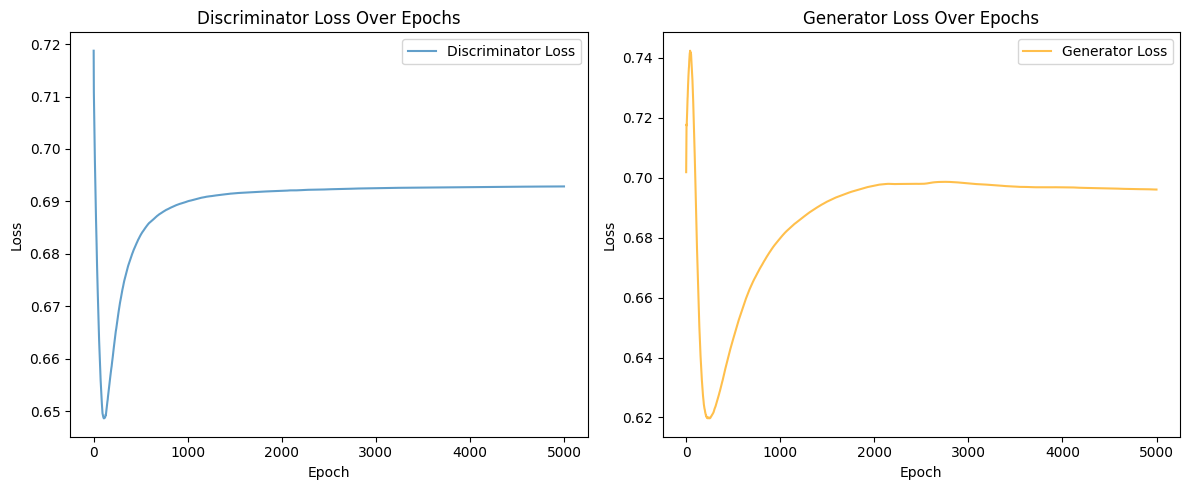

In [13]:
# Plot training losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(d_losses, label="Discriminator Loss", alpha=0.7)
plt.title("Discriminator Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(g_losses, label="Generator Loss", alpha=0.7, color="orange")
plt.title("Generator Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("training_losses.png", dpi=150)
plt.show()

In [14]:
# Generate synthetic samples
n_samples = 200
noise = np.random.normal(0, 1, (n_samples, latent_dim))
generated_data = generator.predict(noise)

# Denormalize to original scale
generated_denormalized = (generated_data + 1) / 2 * (
    feature_max - feature_min + 1e-8
) + feature_min
generated_denormalized = np.clip(
    generated_denormalized, 0, None
)  # Ensure non-negative values
generated_denormalized = np.round(generated_denormalized).astype(
    int
)  # Round to integers

print("Generated synthetic traffic data:")
print(f"Shape: {generated_denormalized.shape}")
generated_denormalized[:10]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Generated synthetic traffic data:
Shape: (200, 2)


array([[3, 3],
       [1, 0],
       [9, 0],
       [1, 0],
       [5, 0],
       [6, 0],
       [4, 1],
       [3, 0],
       [6, 0],
       [3, 1]])

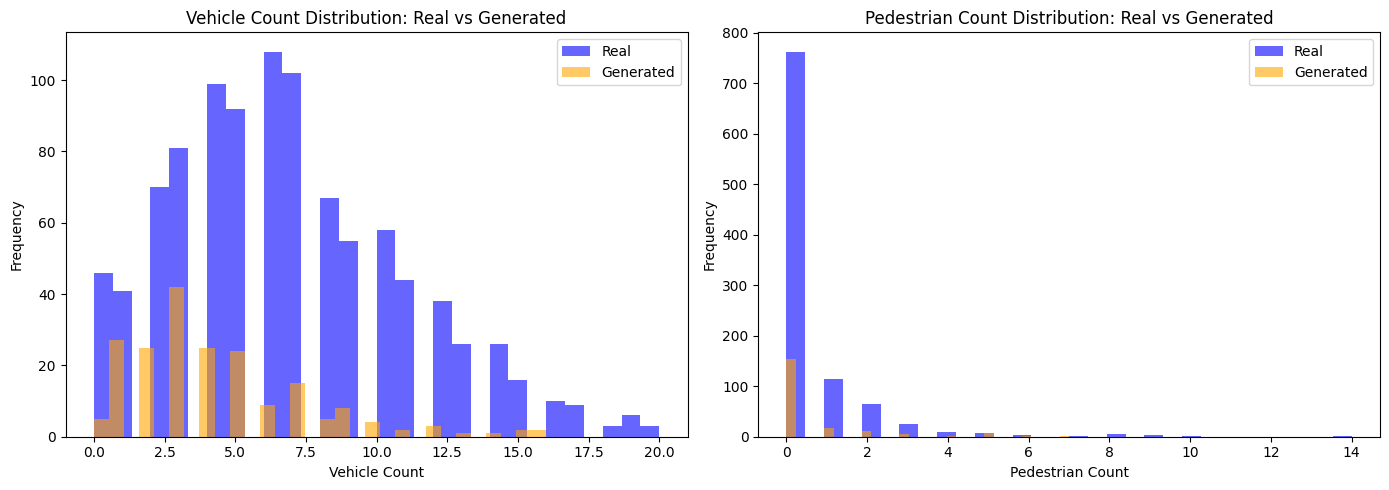

In [15]:
# Compare real vs generated data distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Vehicle Count Distribution
axes[0].hist(feature[:, 0], bins=30, alpha=0.6, label="Real", color="blue")
axes[0].hist(
    generated_denormalized[:, 0], bins=30, alpha=0.6, label="Generated", color="orange"
)
axes[0].set_xlabel("Vehicle Count")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Vehicle Count Distribution: Real vs Generated")
axes[0].legend()

# Pedestrian Count Distribution
axes[1].hist(feature[:, 1], bins=30, alpha=0.6, label="Real", color="blue")
axes[1].hist(
    generated_denormalized[:, 1], bins=30, alpha=0.6, label="Generated", color="orange"
)
axes[1].set_xlabel("Pedestrian Count")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Pedestrian Count Distribution: Real vs Generated")
axes[1].legend()

plt.tight_layout()
plt.savefig("distribution_comparison.png", dpi=150)
plt.show()

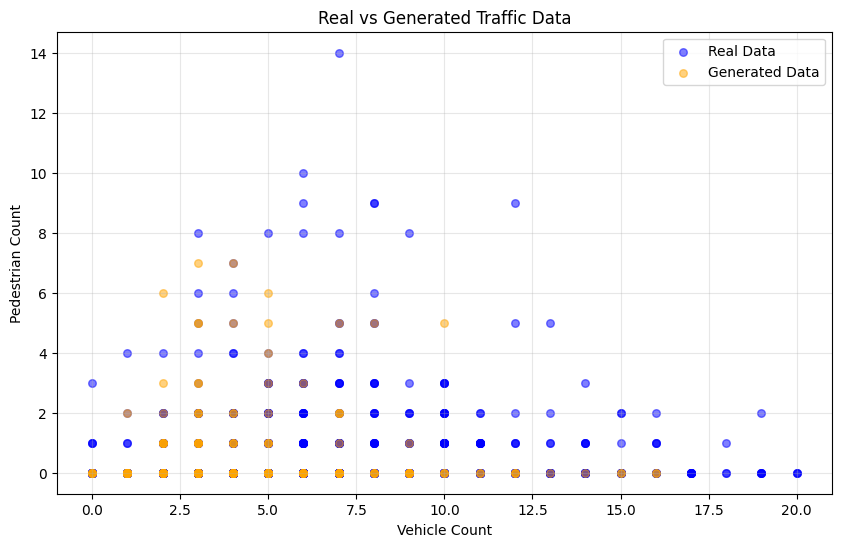

In [16]:
# Scatter plot comparison
plt.figure(figsize=(10, 6))
plt.scatter(feature[:, 0], feature[:, 1], alpha=0.5, label="Real Data", c="blue", s=30)
plt.scatter(
    generated_denormalized[:, 0],
    generated_denormalized[:, 1],
    alpha=0.5,
    label="Generated Data",
    c="orange",
    s=30,
)
plt.xlabel("Vehicle Count")
plt.ylabel("Pedestrian Count")
plt.title("Real vs Generated Traffic Data")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("scatter_comparison.png", dpi=150)
plt.show()

In [17]:
# Compare statistics
print("=" * 50)
print("Statistical Comparison: Real vs Generated Data")
print("=" * 50)

print("\nVehicle Count:")
print(
    f"  Real     - Mean: {feature[:, 0].mean():.2f}, Std: {feature[:, 0].std():.2f}, Min: {feature[:, 0].min()}, Max: {feature[:, 0].max()}"
)
print(
    f"  Generated - Mean: {generated_denormalized[:, 0].mean():.2f}, Std: {generated_denormalized[:, 0].std():.2f}, Min: {generated_denormalized[:, 0].min()}, Max: {generated_denormalized[:, 0].max()}"
)

print("\nPedestrian Count:")
print(
    f"  Real     - Mean: {feature[:, 1].mean():.2f}, Std: {feature[:, 1].std():.2f}, Min: {feature[:, 1].min()}, Max: {feature[:, 1].max()}"
)
print(
    f"  Generated - Mean: {generated_denormalized[:, 1].mean():.2f}, Std: {generated_denormalized[:, 1].std():.2f}, Min: {generated_denormalized[:, 1].min()}, Max: {generated_denormalized[:, 1].max()}"
)

Statistical Comparison: Real vs Generated Data

Vehicle Count:
  Real     - Mean: 6.68, Std: 4.14, Min: 0, Max: 20
  Generated - Mean: 4.41, Std: 3.20, Min: 0, Max: 16

Pedestrian Count:
  Real     - Mean: 0.53, Std: 1.34, Min: 0, Max: 14
  Generated - Mean: 0.60, Std: 1.41, Min: 0, Max: 7


In [18]:
# Create DataFrame with generated data
generated_df = pd.DataFrame(
    generated_denormalized, columns=["vehicle_count", "Pedestrian_count"]
)


# Assign congestion labels based on vehicle count (similar to original logic)
def assign_congestion(vehicle_count):
    if vehicle_count <= 10:
        return "LOW"
    elif vehicle_count <= 20:
        return "Medium"
    else:
        return "High"


generated_df["congestion"] = generated_df["vehicle_count"].apply(assign_congestion)

print("Generated Traffic Data Sample:")
generated_df.head(10)

Generated Traffic Data Sample:


,vehicle_count,Pedestrian_count,congestion
0,3,3,LOW
1,1,0,LOW
2,9,0,LOW
3,1,0,LOW
4,5,0,LOW
5,6,0,LOW
6,4,1,LOW
7,3,0,LOW
8,6,0,LOW
9,3,1,LOW


In [19]:
# Compare congestion distribution
print("\nCongestion Label Distribution:")
print("\nReal Data:")
print(df["congestion"].value_counts())
print("\nGenerated Data:")
print(generated_df["congestion"].value_counts())


Congestion Label Distribution:

Real Data:
congestion
LOW       761
Medium    239
Name: count, dtype: int64

Generated Data:
congestion
LOW       189
Medium     11
Name: count, dtype: int64


In [20]:
# Save the generator model
generator.save("traffic_generator.keras")
print("Generator model saved to 'traffic_generator.keras'")

Generator model saved to 'traffic_generator.keras'


In [21]:
# Save generated data to CSV
generated_df.to_csv("generated_traffic_data.csv", index=False)
print("Generated data saved to 'generated_traffic_data.csv'")

Generated data saved to 'generated_traffic_data.csv'
